### Import and authentification

In [20]:
import ee 
import folium
from datetime import datetime as dt
from IPython.display import Image
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
ee.Initialize()
ee.Authenticate()

Enter verification code: 4/1AY0e-g4sjvGO73IgkiVM9pnSu2R_WI652YckiorVWEANEPoC7CwBxcaBLwo

Successfully saved authorization token.


### Global variables

In [4]:
import os
from google.cloud import storage

BUCKET = 'wagon-data-589-rezler'  # ⚠️ replace with your BUCKET NAME
FOLDER = 'data_forest_guards'
TRAINING_BASE = 'training_patches'
EVAL_BASE = 'eval_patches'

OPTICAL_BANDS = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']
THERMAL_BANDS = ['B10', 'B11']
BANDS = OPTICAL_BANDS + THERMAL_BANDS
RESPONSE = 'fnf'
FEATURES = BANDS + [RESPONSE]

# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 256
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]

COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

# Specify model training parameters.
BATCH_SIZE = 16
# EPOCHS = 10
BUFFER_SIZE = 2000
# OPTIMIZER = 'SGD'
# LOSS = 'MeanSquaredError'
# METRICS = ['RootMeanSquaredError']
   

### Data

#### X

In [14]:
# Use Landsat 8 surface reflectance data.
l8sr = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')

# Cloud masking function from GEE
def maskL8sr(image):
  cloudShadowBitMask = ee.Number(2).pow(3).int()
  cloudsBitMask = ee.Number(2).pow(5).int()
  qa = image.select('pixel_qa')
  mask1 = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
    qa.bitwiseAnd(cloudsBitMask).eq(0))
  mask2 = image.mask().reduce('min')
  mask3 = image.select(OPTICAL_BANDS).gt(0).And(
          image.select(OPTICAL_BANDS).lt(10000)).reduce('min')
  mask = mask1.And(mask2).And(mask3)
  return image.select(OPTICAL_BANDS).divide(10000).addBands(
          image.select(THERMAL_BANDS).divide(10).clamp(273.15, 373.15)
            .subtract(273.15).divide(100)).updateMask(mask)

# The image input data is a cloud-masked median composite.
image = l8sr.filterDate('2015-01-01', '2017-12-31').map(maskL8sr).median()

# Use folium to visualize the imagery.
mapid = image.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3})
map = folium.Map(location=[48.9, 2.5])
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite',
    opacity = 0.5
  ).add_to(map)

mapid = image.getMapId({'bands': ['B11'], 'min': 0, 'max': 0.5})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='thermal',
    opacity = 0.5
  ).add_to(map)
map.add_child(folium.LayerControl())
map

#### Target

In [38]:
jaxa = ee.ImageCollection('JAXA/ALOS/PALSAR/YEARLY/FNF').filterDate('2017-01-01', '2017-12-31').median()

jaxa_norm = jaxa.divide(100).float()

palette = ['006400',
           'FEFF99',
         #  '0000FF'
          ]
mapid = jaxa.getMapId({'bands': ['fnf'],
                       'min': 1, 
                       'max': 2, 
                      'palette':palette
                      })
map = folium.Map(location=[48.9, 2.5])


folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='jaxa fnf',
    color=palette,
    opacity = 1
  ).add_to(map)
map.add_child(folium.LayerControl())
map

### Stacking X and y

In [39]:

featureStack = ee.Image.cat([
  image.select(BANDS),
  jaxa.select(RESPONSE)
]).float()

list = ee.List.repeat(1, KERNEL_SIZE)
lists = ee.List.repeat(list, KERNEL_SIZE)
kernel = ee.Kernel.fixed(KERNEL_SIZE, KERNEL_SIZE, lists)

arrays = featureStack.neighborhoodToArray(kernel)

### Areas of interests

In [10]:
# create our own areas of interests
# training features collection
rect_train = ee.Geometry.Rectangle([3.327248985602229, 46.600827791084875, 4.689553673102229,47.70649093701327])
trainingPolys = ee.FeatureCollection([rect_train])
# eval features collections
rect_eval = ee.Geometry.Rectangle([-0.7016469211726672,46.88962161312492, 0.9353159694523328,47.64998631126759])
evalPolys= ee.FeatureCollection([rect_eval])

In [11]:
trainingPolys.getInfo()

{'type': 'FeatureCollection',
 'columns': {'system:index': 'String'},
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[3.327248985602229, 46.600827791084875],
      [4.689553673102229, 46.600827791084875],
      [4.689553673102229, 47.70649093701327],
      [3.327248985602229, 47.70649093701327],
      [3.327248985602229, 46.600827791084875]]]},
   'id': '0',
   'properties': {}}]}

In [12]:
###################################################
###   DEFINE OUR COLLECTSIONS OF AREAS OF INTEREST
################################################
# trainingPolys = ee.FeatureCollection('projects/google/DemoTrainingGeometries')
# evalPolys = ee.FeatureCollection('projects/google/DemoEvalGeometries')

polyImage = ee.Image(0).byte().paint(trainingPolys, 1).paint(evalPolys, 2)
polyImage = polyImage.updateMask(polyImage)

mapid = polyImage.getMapId({'min': 1, 'max': 2, 'palette': ['red', 'blue']})
map = folium.Map(location=[47., 0.], zoom_start=5)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='training polygons',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

In [23]:
trainingPolysList = trainingPolys.toList(trainingPolys.size())
evalPolysList = evalPolys.toList(evalPolys.size())


In [26]:
print(ee.Feature(trainingPolysList.get(0)).geometry())

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Feature.geometry",
    "arguments": {
      "feature": {
        "functionInvocationValue": {
          "functionName": "List.get",
          "arguments": {
            "index": {
              "constantValue": 0
            },
            "list": {
              "functionInvocationValue": {
                "functionName": "Collection.toList",
                "arguments": {
                  "collection": {
                    "functionInvocationValue": {
                      "functionName": "Collection",
                      "arguments": {
                        "features": {
                          "arrayValue": {
                            "values": [
                              {
                                "functionInvocationValue": {
                                  "functionName": "Feature",
                                  "arguments": {
                                    "geometry": {
            

### Export data TFRecords

In [46]:
# Convert the feature collections to lists for iteration.
trainingPolysList = trainingPolys.toList(trainingPolys.size())
evalPolysList = evalPolys.toList(evalPolys.size())

# These numbers determined experimentally.
n = 2 # Number of shards in each polygon.
N = 20 # Total sample size in each polygon.

# Export all the training data (in many pieces), with one task 
# per geometry.
for g in range(trainingPolys.size().getInfo()):
    geomSample = ee.FeatureCollection([])
    for i in range(n):
        print(i)
        sample = arrays.sample(
          region = ee.Feature(trainingPolysList.get(g)).geometry(), 
          scale = 30,
          numPixels = N / n, # Size of the shard.
          seed = i,
          tileScale = 8
        )
        geomSample = geomSample.merge(sample)

    desc = TRAINING_BASE + '_g' + str(g)

    
    task = ee.batch.Export.table.toCloudStorage(
                                                collection = geomSample,
                                                description = desc,
                                                bucket = BUCKET,
                                                fileNamePrefix = FOLDER + '/' + desc,
                                                fileFormat = 'TFRecord',
                                                selectors = BANDS + [RESPONSE], 
                                                )
    task.start()
    print('g : ' , g)
    
    
# Monitor task progress
# Code Extracted here:
# https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/TF_demo1_keras.ipynb
# import time 
# while task.active():
#   print('Polling for task (id: {}).'.format(task.id))
#   time.sleep(5)
	
# print('Done!')

# Export all the evaluation data.
for g in range(evalPolys.size().getInfo()):
    geomSample = ee.FeatureCollection([])
    for i in range(n):
        sample = arrays.sample(
                              region = ee.Feature(evalPolysList.get(g)).geometry(), 
                              scale = 30,
                              numPixels = N / n,
                              seed = i,
                              tileScale = 8
                            )
        geomSample = geomSample.merge(sample)

desc = EVAL_BASE + '_g' + str(g)
task = ee.batch.Export.table.toCloudStorage(
                                        collection = geomSample,
                                        description = desc,
                                        bucket = BUCKET,
                                        fileNamePrefix = FOLDER + '/' + desc,
                                        fileFormat = 'TFRecord',
                                        selectors = BANDS + [RESPONSE]
                                        )
task.start()
task.status()
# Monitor task progress
# Code Extracted here:
# https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/TF_demo1_keras.ipynb
import time 
while task.active():
  print('Polling for task (id: {}).'.format(task.id))
  time.sleep(5)
task.status()

0
1
g :  0


{'state': 'READY',
 'description': 'eval_patches_g0',
 'creation_timestamp_ms': 1622020386246,
 'update_timestamp_ms': 1622020386246,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_FEATURES',
 'id': 'BCGOAEGXHGCLSHQG5AD64R4H',
 'name': 'projects/earthengine-legacy/operations/BCGOAEGXHGCLSHQG5AD64R4H'}

### Parse TFRecords and get back tensors

In [6]:
def parse_tfrecord(example_proto):
    """The parsing function.
    Read a serialized example into the structure defined by FEATURES_DICT.
    Args:
    example_proto: a serialized Example.
    Returns:
    A dictionary of tensors, keyed by feature name.
    """
    return tf.io.parse_single_example(example_proto, FEATURES_DICT)


def to_tuple(inputs):
    """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
    Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
    Args:
    inputs: A dictionary of tensors, keyed by feature name.
    Returns:
    A tuple of (inputs, outputs).
    """
    inputsList = [inputs.get(key) for key in FEATURES]
    stacked = tf.stack(inputsList, axis=0)
    # Convert from CHW to HWC
    stacked = tf.transpose(stacked, [1, 2, 0])
    return stacked[:,:,:len(BANDS)], stacked[:,:,len(BANDS):]


def get_dataset(pattern):
    """Function to read, parse and format to tuple a set of input tfrecord files.
    Get all the files matching the pattern, parse and convert to tuple.
    Args:
    pattern: A file pattern to match in a Cloud Storage bucket.
    Returns:
    A tf.data.Dataset
    """
    glob = tf.io.gfile.glob(pattern)
    dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
    dataset = dataset.map(to_tuple, num_parallel_calls=5)
    return dataset

In [7]:
def get_training_dataset():
    """Get the preprocessed training dataset
    Returns: 
    A tf.data.Dataset of training data.
    """
    glob = 'gs://' + BUCKET + '/' + FOLDER + '/' + TRAINING_BASE + '*'
    dataset = get_dataset(glob)
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
    return dataset

training = get_training_dataset()

print(iter(training.take(1)).next())

(<tf.Tensor: shape=(16, 256, 256, 9), dtype=float32, numpy=
array([[[[0.0297    , 0.03315   , 0.06655   , ..., 0.10675   ,
          0.185     , 0.165     ],
         [0.03135   , 0.0342    , 0.06625   , ..., 0.11165   ,
          0.1865    , 0.1655    ],
         [0.03135   , 0.0342    , 0.06625   , ..., 0.11165   ,
          0.1865    , 0.1655    ],
         ...,
         [0.0275    , 0.03625   , 0.0697    , ..., 0.10275   ,
          0.16      , 0.1485    ],
         [0.02695   , 0.03705   , 0.0733    , ..., 0.0899    ,
          0.1615    , 0.15      ],
         [0.0303    , 0.0409    , 0.07145   , ..., 0.1061    ,
          0.1635    , 0.1525    ]],

        [[0.03075   , 0.03445   , 0.06795   , ..., 0.11035   ,
          0.1855    , 0.164     ],
         [0.0319    , 0.03535   , 0.0684    , ..., 0.11635   ,
          0.187     , 0.165     ],
         [0.0319    , 0.03535   , 0.0684    , ..., 0.11635   ,
          0.187     , 0.165     ],
         ...,
         [0.0263    , 0.0339

In [8]:
type(training)

tensorflow.python.data.ops.dataset_ops.RepeatDataset

In [54]:
images , labels = iter(training.take(1)).next()
labels[0,:,:,:].numpy()

array([[[2.],
        [2.],
        [2.],
        ...,
        [2.],
        [2.],
        [2.]],

       [[2.],
        [2.],
        [2.],
        ...,
        [2.],
        [2.],
        [2.]],

       [[2.],
        [2.],
        [2.],
        ...,
        [2.],
        [2.],
        [2.]],

       ...,

       [[2.],
        [2.],
        [2.],
        ...,
        [2.],
        [2.],
        [2.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [2.],
        [2.],
        [2.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [2.],
        [2.],
        [2.]]], dtype=float32)

In [39]:
images[i, :, : , 3].numpy(), images[i, :, : , 2].numpy(), images[i, :, : , 1].numpy()

(array([[0.0293 , 0.0281 , 0.0281 , ..., 0.03285, 0.03285, 0.0303 ],
        [0.0333 , 0.02965, 0.02965, ..., 0.0545 , 0.0545 , 0.0431 ],
        [0.033  , 0.0318 , 0.0318 , ..., 0.09415, 0.09415, 0.085  ],
        ...,
        [0.0453 , 0.0371 , 0.0371 , ..., 0.03285, 0.03285, 0.0312 ],
        [0.0435 , 0.0444 , 0.0444 , ..., 0.0334 , 0.033  , 0.0321 ],
        [0.0463 , 0.0496 , 0.0496 , ..., 0.0316 , 0.0319 , 0.03305]],
       dtype=float32),
 array([[0.0427 , 0.04475, 0.04475, ..., 0.0424 , 0.0424 , 0.0425 ],
        [0.044  , 0.0448 , 0.0448 , ..., 0.062  , 0.062  , 0.0551 ],
        [0.0446 , 0.0446 , 0.0446 , ..., 0.08525, 0.08525, 0.0805 ],
        ...,
        [0.05355, 0.0517 , 0.0517 , ..., 0.0455 , 0.0455 , 0.04305],
        [0.05765, 0.0648 , 0.0648 , ..., 0.0463 , 0.0451 , 0.04495],
        [0.059  , 0.0667 , 0.0667 , ..., 0.0447 , 0.0435 , 0.0443 ]],
       dtype=float32),
 array([[0.02405   , 0.0243    , 0.0243    , ..., 0.02265   , 0.02265   ,
         0.0221    ],
  

In [49]:
import numpy as np
np.max(np.flip(images[i, :, : , 1:4].numpy(), axis=2), axis=2)

array([[0.0601 , 0.05725, 0.0408 , ..., 0.06645, 0.06645, 0.0697 ],
       [0.0506 , 0.0462 , 0.0322 , ..., 0.06915, 0.06915, 0.06925],
       [0.0516 , 0.04615, 0.036  , ..., 0.07195, 0.07195, 0.0692 ],
       ...,
       [0.0273 , 0.02825, 0.02825, ..., 0.07145, 0.0621 , 0.0621 ],
       [0.028  , 0.0282 , 0.0282 , ..., 0.07095, 0.06025, 0.06025],
       [0.0271 , 0.0265 , 0.0265 , ..., 0.06315, 0.0608 , 0.0608 ]],
      dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


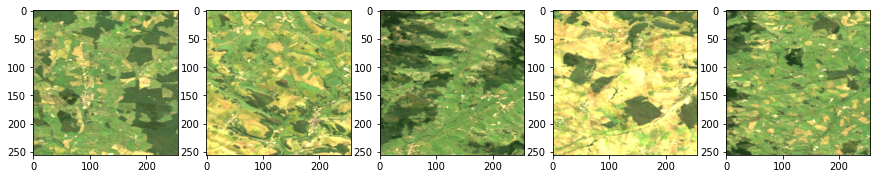

In [53]:
fig = plt.figure(figsize=(15,7))

for i in range(5):
    plt.subplot(1, 5, i+1 )
    plt.imshow(np.flip(images[i, :, : , 1:4].numpy(), axis=2)*10)
    

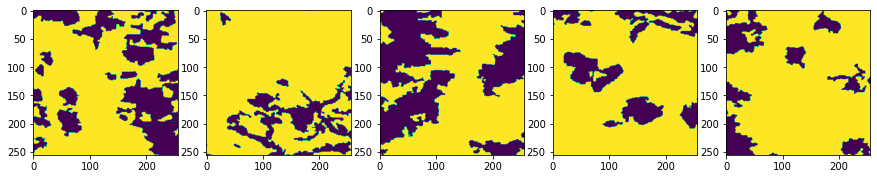

In [34]:
fig = plt.figure(figsize=(15,7))

for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(labels[i, :, : , :])


In [35]:
FEATURES_DICT

{'B1': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None),
 'B2': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None),
 'B3': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None),
 'B4': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None),
 'B5': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None),
 'B6': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None),
 'B7': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None),
 'B10': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None),
 'B11': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None),
 'fnf': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None)}

In [9]:
def get_eval_dataset():
    """Get the preprocessed evaluation dataset
    Returns: 
    A tf.data.Dataset of evaluation data.
    """
    glob = 'gs://' + BUCKET + '/' + FOLDER + '/' + EVAL_BASE + '*'
    dataset = get_dataset(glob)
    dataset = dataset.batch(1).repeat()
    return dataset

evaluation = get_eval_dataset()